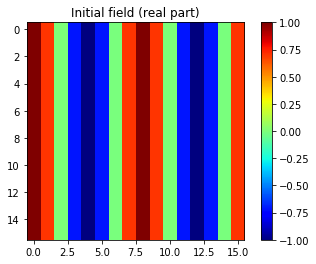

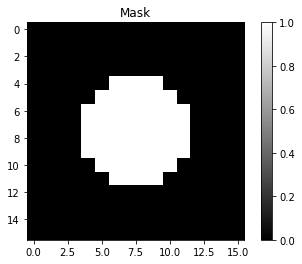

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import copy


def empty_mask(size):
    return np.zeros((size,size))

def circular_mask(size):
    y,x = np.mgrid[:size, :size]
    M = np.zeros((size,size))
    x0 = y0 = (size-1)/2
    r = size/4
    M[(x-x0)**2+(y-y0)**2<=r**2]=1
    return M

def rectangle_mask(size):
    y,x = np.mgrid[:size, :size]
    M = np.zeros((size,size))
    x0 = y0 = (size-1)/2
    r = size/4
    M[((x-x0)**2<=r**2)*((y-y0)**2<=r**2)]=1
    return M
    

    
def get_plane_wave(E0,k,size):
    y,x = np.mgrid[:size, :size]
    a = np.pi*0/180
    E = E0*np.exp(-1j*k*(x*np.cos(a)+y*np.sin(a)))
    return(E) 
    
def get_greenfun(r,k):
    return (1j/4)*scipy.special.hankel1(0,k*r)

def get_green_matrix(k,size):
    j,i = np.mgrid[:size, :size]
    ij_block = np.sqrt((i-1/2)**2+j**2)
    green_mat = get_greenfun(ij_block,k)
    return green_mat

# def get_toeplitz_mat(ij_block):
#     ij_block = copy.deepcopy(ij_block)
#     T = np.block([[ij_block,ij_block[:,:0:-1]],
#                   [ij_block[:0:-1,:],ij_block[:0:-1,:0:-1]]])
#     return T

def get_toeplitz_mat(ij_block):
    ij_block = copy.deepcopy(ij_block)
    T1 = np.hstack((ij_block,ij_block[:,:0:-1]))
    T2 = np.hstack((ij_block[:0:-1,:],ij_block[:0:-1,:0:-1]))
    T = np.vstack((T1,T2))
    return T
    
def G_matvec(vec,k):
    size = int(np.sqrt(vec.shape[0]))
    G_block = get_green_matrix(k,size)
    G = get_toeplitz_mat(G_block)
    mat = np.zeros((2*size-1,2*size-1),dtype = np.complex64)
    mat_block = vec.reshape((-1,size))
    mat[:size,:size] = mat_block
    out_mat = np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(mat))
    out = out_mat[:size,:size].reshape((-1,1))
    return out

def get_eps_from_mask(e,mask):
    return (e-1)*mask.reshape((-1,1))+1

def matvec(x,eps,k):
    x = x.reshape((-1,1))
    #print(x)
    size = x.shape[0]
    chi = k**2*(eps - 1)
    return x-G_matvec(x*chi,k)

def old_matvec(x,mask,k,e):
    eps = get_eps_from_mask(e,mask)
    return matvec(x,eps,k)

def visualize(data,title = "",cmap='jet',):
    plt.title(title)
    neg = plt.imshow(data, cmap=cmap, interpolation='none')
    plt.colorbar(neg)
    plt.show()


    
def solve(E,eps0,eps1):
    return E


size = 16
e = 2.25
k  = 2*np.pi/(size/2)
F = get_plane_wave(1,k,size)
mask = circular_mask(size)
eps = get_eps_from_mask(e,mask)
visualize(F.real,"Initial field (real part)")
#mask = rectangle_mask(size)
mask = circular_mask(size)
visualize(mask,"Mask","gray")



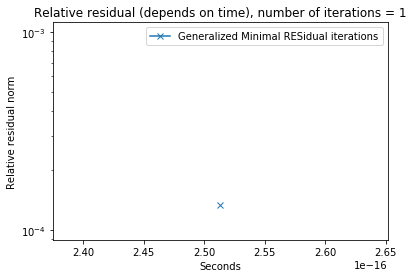

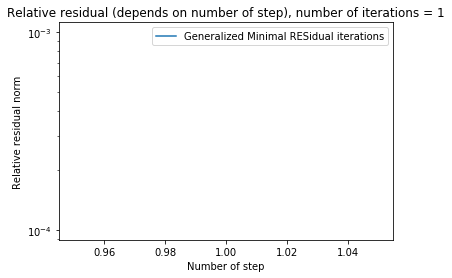

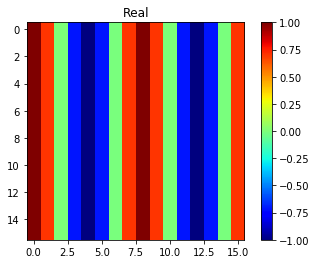

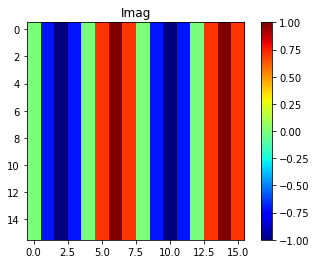

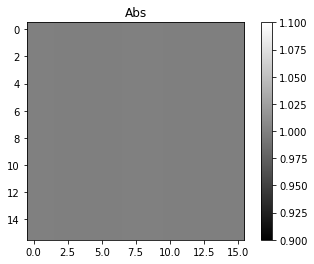

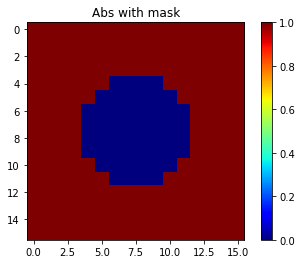

In [48]:
import scipy.sparse.linalg as spla
import inspect
import time

def plot__solution_re_im_abs_mask(solution, size):
    solution_re = solution.real.reshape(-1,size)
    solution_im = solution.imag.reshape(-1,size)
    solution_abs = np.abs(solution).reshape(-1,size)
    solution_abs_mask = np.abs(solution).reshape(-1,size)*(1-mask)
    visualize(solution_re,"Real")
    visualize(solution_im,"Imag")
    visualize(solution_abs,"Abs","gray")
    visualize(solution_abs_mask,"Abs with mask")
    return solution_re, solution_im, solution_abs, solution_abs_mask

def plot_relative_residuals_norms(t, residuals, relative_vector):
    plt.semilogy(t, residuals/np.linalg.norm(relative_vector), 'x-', label="Generalized Minimal RESidual iterations")
    plt.legend()
    plt.title('Relative residual (depends on time), number of iterations = %i' % len(residuals))
    plt.xlabel('Seconds')
    plt.ylabel('Relative residual norm')
    plt.show()
    plt.semilogy(np.arange(len(residuals), 0, -1), residuals/np.linalg.norm(relative_vector), label="Generalized Minimal RESidual iterations")
    plt.legend()
    plt.title('Relative residual (depends on number of step), number of iterations = %i' % len(residuals))
    plt.xlabel('Number of step')    
    plt.ylabel('Relative residual norm')
    plt.show()
    
def gmres_solver(A, b, x0, maxiter, tol, 
                 draw_graph_flag = False, 
                 convergence_info = False, 
                 display_convergence_info = False,
                 display_achieved_tolerance = False):
    gmres_residuals_with_t = []
    t0 = time.time()
    solution, info =  spla.gmres(A, b,  x0=x0, maxiter = maxiter, tol = tol, restart  = maxiter, callback = lambda x:
        gmres_residuals_with_t.append([(inspect.currentframe().f_back).f_locals['resid'], time.time()])
        )
    gmres_residuals_with_t = np.array(gmres_residuals_with_t).T
    gmres_residuals_with_t[1] = gmres_residuals_with_t[1]-t0
    gmres_t, gmres_residuals = gmres_residuals_with_t
    if (display_convergence_info == True):
        if (info == 0):
            print("Status: Converged, successful exit")
        else:
            if (info > 0):
                print("Status: Convergence to tolerance not achieved, number of iterations")
            else:
                print("Status: Illegal input or breakdown")
    if ( draw_graph_flag == True ):
        plot_relative_residuals_norms(gmres_t, gmres_residuals, b)        
    if ( display_achieved_tolerance == True):
        print('Achieved tolerance = ', np.linalg.norm(A.dot(solution.reshape(-1,1))-b)/np.linalg.norm(b))
    if (convergence_info == True):
        return solution, info
    return solution

def launch_solver(eps, k, maxiter=300, tol = 1e-6):
    size = int(np.sqrt(eps.shape[0]))
    A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda x: matvec(x,eps,k))
    b = get_plane_wave(1,k,size).reshape(-1,1)
    x0 = np.ones(size**2).reshape(-1,1)
    solution, info = gmres_solver(A, b, x0, 
                               maxiter=maxiter, 
                               tol=tol,
                               convergence_info = True)
    return solution, info

def show_residuals(eps, k, maxiter=300, tol = 1e-6):
    size = int(np.sqrt(eps.shape[0]))
    A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda x: matvec(x,eps,k))
    b = get_plane_wave(1,k,size).reshape(-1,1)
    x0 = np.ones(size**2).reshape(-1,1)
    gmres_solver(A, b, x0, 
                 maxiter=maxiter, 
                 tol=tol,
                 draw_graph_flag = True)
    
solution, info = launch_solver(eps=eps, k=k)
show_residuals(eps=eps, k=k)
solution_re, solution_im, solution_abs, solution_abs_mask = plot__solution_re_im_abs_mask(solution, size)

In [55]:
# import cvxpy as cvx

# size = 2
# k  = 2*np.pi/(size/7)
# F = get_plane_wave(1,k,size)

# x = cvx.Variable(size**2)
# eps = cvx.Variable(size**2)



# # lambda val: matvec2(val,eps,k,e
# obj = cvx.Maximize(cvx.max_entries(x))
# #A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda val: val)
# print(A.dot([1,1,0,0]))
# costrs = [matvec2(x,eps,k,e)==F]
# prob = cvx.Problem(obj,costrs)
# prob.solve()
# print(prob.value)



-1.0
-1.00000000142
-1.00000000142
-1.00000000121
-1.00000000142
-1.00000000147
-1.0000000021
-1.00000000252
-1.00000000254
-1.00000000257
-1.00000000142
-1.00000000134
-1.00000000153
-1.00000000144
-1.00000000203
-1.00000000246
-1.00000000252
-1.00000000142
-1.00000000142
-1.00000000118
-1.00000000137
-1.00000000141
-1.00000000202
-1.00000000248
-1.00000000252
-1.00000000257
-1.00000000142
-1.00000000136
-1.00000000152
-1.0000000014
-1.00000000197
-1.00000000243
-1.0000000025
-1.00000000142
-1.00000000142
-1.00000000114
-1.00000000129
-1.00000000132
-1.00000000193
-1.00000000244
-1.0000000025
-1.00000000257
-1.00000000142
-1.00000000134
-1.00000000147
-1.00000000133
-1.00000000188
-1.00000000239
-1.00000000248
-1.00000000142
-1.00000000142
-1.00000000112
-1.00000000123
-1.00000000127
-1.00000000187
-1.00000000241
-1.00000000249
-1.00000000257
-1.00000000142
-1.00000000132
-1.00000000141
-1.00000000126
-1.0000000018
-1.00000000235
-1.00000000246
-1.00000000142
-1.00000000142
-1.0000000

-1.46119247283
-1.46119247277
-1.46119247282
-1.46119247323
-1.4611924733
-1.46119247155
-1.46119247256
-1.46119247328
-1.461192474
-1.46119247444
-1.46119247354
-1.46119247304
-1.46119247304
-1.46119247276
-1.46119247301
-1.46119247306
-1.46119247339
-1.46119247298
-1.46119247315
-1.46119247271
-1.46119247293
-1.46119247218
-1.46119247377
-1.46119247383
-1.46119247405
-1.46119247346
-1.46119247361
-1.46119247335
-1.46119247436
-1.46119247467
-1.46119247339
-1.46119247313
-1.46119247332
-1.46119247337
-1.46119247284
-1.4611924731
-1.4611924739
-1.46119247416
-1.46119247558
-1.46119247474
-1.46119247323
-1.46119247363
-1.46119247336
-1.46119247346
-1.46119247351
-1.46119247338
-1.46119247334
-1.46119247339
-1.4611924728
-1.4611924722
-1.46119247331
-1.4611924736
-1.46119247334
-1.46119247243
-1.46119247425
-1.4611924745
-1.46119247304
-1.46119247337
-1.4611924734
-1.46119247339
-1.46119247347
-1.46119247355
-1.46119247384
-1.46119247379
-1.46119247309
-1.46119247325
-1.46119247254
-1.46

-3.93668216176
-3.93668213012
-3.93668217427
-3.93668219596
-3.93668215086
-3.93668217316
-3.93668217999
-3.93668216137
-3.93668215877
-3.93668214601
-3.93668216446
-3.9366821678
-3.93668214472
-3.9366821628
-3.93668216318
-3.93668217292
-3.93668217172
-3.93668216241
-3.93668216957
-3.9366821721
-3.93668216446
-3.93668216826
-3.93668215784
-3.93668217091
-3.93668216831
-3.93668216331
-3.93668216836
-3.93668213682
-3.93668215035
-3.9366821696
-3.93668215649
-3.93668216952
-3.93668213574
-3.93668217084
-3.93668216802
-3.93668216586
-3.93668216568
-3.93668216355
-3.93668215544
-3.9366821673
-3.93668216606
-3.9366821677
-3.93668215708
-3.93668215126
-3.93668216468
-3.93668216287
-3.93668216896
-3.93668215787
-3.93668217146
-3.93668217201
-3.93668216461
-3.93668215263
-3.9366821476
-3.93668215696
-3.93668215344
-3.93668215801
-3.93668216761
-3.93668215954
-3.93668216075
-3.93668218039
-3.93668216651
-3.93668216665
-3.93668215909
-3.93668216573
-3.93668215173
-3.93668217035
-3.93668215306
-3

-4.31220387511
-4.31220388086
-4.31220387681
-4.31220387524
-4.312203863
-4.31220387727
-4.3122038774
-4.31220385427
-4.31220387608
-4.31220387655
-4.3122038824
-4.31220388675
-4.31220388757
-4.31220388348
-4.31220389675
-4.31220389161
-4.31220388062
-4.312203884
-4.31220386653
-4.3122038572
-4.31220387955
-4.31220387835
-4.31220387687
-4.3122038671
-4.31220387895
-4.31220388267
-4.31220388891
-4.31220387789
-4.31220388265
-4.31220388211
-4.31220388204
-4.31220388003
-4.31220386588
-4.31220387554
-4.31220387629
-4.31220386001
-4.31220387817
-4.3122038804
-4.31220387714
-4.31220388147
-4.31220387138
-4.31220387399
-4.31220387545
-4.31220387731
-4.31220386918
-4.3122038846
-4.31220388481
-4.31220388123
-4.31220388188
-4.31220387358
-4.31220387584
-4.31220388776
-4.3122038839
-4.31220387835
-4.3122038876
-4.31220388123
-4.31220386344
-4.31220387204
-4.31220387376
-4.31220388656
-4.3122038652
-4.31220387238
-4.31220386354
-4.31220388056
-4.31220388325
-4.31220387005
-4.31220387861
-4.31220

-4.62415422585
-4.62415421988
-4.62415421648
-4.62415421845
-4.6241542304
-4.6241542329
-4.6241542174
-4.62415422115
-4.62415421714
-4.62415423749
-4.62415420654
-4.62415421516
-4.62415422099
-4.62415422616
-4.62415421711
-4.62415422451
-4.62415421566
-4.62415422625
-4.62415423452
-4.62415421592
-4.62415422799
-4.62415422144
-4.62415422679
-4.62415422845
-4.62415418617
-4.62415422461
-4.62415421254
-4.624154218
-4.62415422669
-4.62415422439
-4.62415422889
-4.62415422257
-4.62415421668
-4.62415422261
-4.62415422007
-4.62415421967
-4.62415422366
-4.62415421595
-4.62415422577
-4.62415423222
-4.6241542214
-4.62415421498
-4.62415422195
-4.62415421778
-4.62415420922
-4.62415422011
-4.6241542171
-4.62415421565
-4.62415422574
-4.62415422381
-4.62415422643
-4.62415423426
-4.62415421763
-4.624154224
-4.62415421901
-4.62415422819
-4.62415421994
-4.62415422805
-4.62415422373
-4.62415422111
-4.62415422235
-4.62415420921
-4.62415420811
-4.62415422406
-4.62415421885
-4.62415420482
-4.62415422312
-4.6

-4.63662748784
-4.6366274971
-4.63662749599
-4.63662749294
-4.63662749736
-4.63662748695
-4.63662749958
-4.63662749962
-4.63662751307
-4.63662752234
-4.63662749311
-4.63662751114
-4.63662752025
-4.63662752488
-4.63662751675
-4.63662747081
-4.63662750402
-4.63662748369
-4.63662748426
-4.63662751738
-4.63662748915
-4.63662749663
-4.63662751375
-4.63662750034
-4.63662749471
-4.63662747818
-4.63662752629
-4.63662749312
-4.63662749021
-4.63662749417
-4.6366274974
-4.63662748723
-4.63662750123
-4.63662748836
-4.63662750495
-4.63662748675
-4.63662749264
-4.6366274878
-4.63662749731
-4.63662748862
-4.63662748653
-4.63662750231
-4.63662750374
-4.63662750635
-4.63662749822
-4.63662749536
-4.63662748421
-4.63662750285
-4.63662750282
-4.63662750233
-4.63662750051
-4.63662750126
-4.63662748866
-4.63662751767
-4.63662750849
-4.6366275242
-4.6366275026
-4.63662750846
-4.63662749807


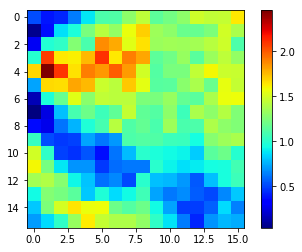

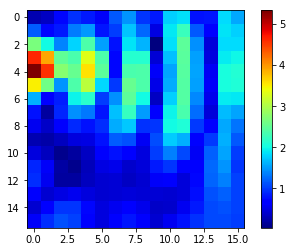

In [52]:
from scipy.optimize import minimize

def objective(eps):
    #print("o")
    eps = eps.reshape((-1,1))
    x, info = launch_solver(eps=eps, k=k)
    x_empty_ind = np.argwhere((0.9<eps)*(eps<1.1))
    x_empty = x[x_empty_ind]
    if info != 0:
        raise RuntimeError()
    obj = -np.max(np.abs(x_empty))
    print(obj)
    return obj
#x0,info  = launch_solver(eps=eps, k=k)
eps[:,:]=1
sol = minimize(objective,eps,method="CG",options={'maxiter': 6})
params = sol.x.reshape(-1,size)
visualize(params)
pole, info = launch_solver(eps=params.reshape(-1,1), k=k)
#print(pole)
visualize(np.abs(pole.reshape(-1,size)))
    